<a href="https://colab.research.google.com/github/Rocketpuppet/Colab-Projects/blob/main/Digit_classification_with_neural_network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use a library called `numpy` for vector/matrix operations.

# 1. Implement the neural network

According to the definition, we should implement a 2 hidden layer neural network, with ReLU activations for each hidden layer, and an output layer with softmax activation.

Neural network:
$$
y = softmax(y') \\
y' = W^{(3)} h^{(2)} \\
h^{(2)} = relu({h^{(2)}}') \\
{h^{(2)}}' = W^{(2)} h^{(1)} \\
h^{(1)} = relu({h^{(1)}}') \\
{h^{(1)}}' = W^{(1)}x \\
\\
softmax(z)_i = \frac{e^{z_i}}{Σ_{k\in K}{e^{z_{k}}}} \\
relu(z)_i = z_i \text{ if } z_i > 0 \text{, otherwise } 0
$$

Dimensions:
- $y$ is a vector of size K, where K is number of output classes
- $h^{(2)}$ is a vector of size H2
- $h^{(1)}$ is a vector of size H1
- $x$ is a vector of size N, where N is number of input dimensions
- $W^{(1)}$ is a matrix of size H1 * N
- $W^{(2)}$ is a matrix of size H2 * H1
- $W^{(3)}$ is a matrix of size K * H2

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

In [ ]:
def relu(z):
    return np.maximum(0,z)

def softmax(z):
    ezk = np.exp(z - np.max(z))
    sum = np.sum(ezk)

    return ezk/sum

In [ ]:
class Model:
    def __init__(self, N, H1, H2, K):
        """Initialize the model."""
        # Size [H1 * N]
        self.W_xh1 = np.random.randn(H1, N) * 0.01
        # Size [H2 * H1]
        self.W_h1h2 = np.random.randn(H2, H1) * 0.01
        # Size [K * H2]
        self.W_h2y = np.random.randn(K, H2) * 0.01

    def forward(self, x):
        """Compute forward pass given an input vector x."""
        # Size [H1, 1]
        h1_ =  x @ self.W_xh1.T
        h1 = relu(h1_)

        # Size [H2, 1]
        h2_ =  h1 @ self.W_h1h2.T
        h2 = relu(h2_)

        # Size [K, 1]
        y_ = h2 @ self.W_h2y.T

        y = softmax(y_)

        return [h1_,h1,h2_,h2,y_,y]

In [ ]:
test = Model(64, 2, 10, 10)

x = np.random.uniform(low=0, high=10, size=[8, 64])

y = test.forward(x)

np.sum(y[-1])



0.9999999999999998

# 2. Implement loss function and derivatives

We will train out neural network with the cross-entropy loss function:

$$
L(y,t) = - \Sigma_{i \in K} t_i \log y_i \\
y, t \in \mathbb{R}^K
$$

We need to get derivatives of the loss function with respect to all parameters in our neural network: $W^{(1)}, W^{(2)}, W^{(3)}$

$$
\frac{dL}{dW^{(3)}_{ij}} = \frac{dL}{dy_i} \frac{dy_i}{dy'_i} \frac{dy'_i}{dW^{(3)}_{ij}} \\
\frac{dL}{dW^{(2)}_{jk}} = \Sigma_i \frac{dL}{dy_i} \frac{dy_i}{dy'_i} \frac{dy'_i}{dh^{(2)}_j} \frac{dh^{(2)}_j}{d{h^{(2)}}'_j} \frac{d{h^{(2)}}'_j}{dW^{(2)}_{jk}} \\
\frac{dL}{dW^{(1)}_{kn}} = \Sigma_i \Sigma_j \frac{dL}{dy_i} \frac{dy_i}{dy'_i} \frac{dy'_i}{dh^{(2)}_j} \frac{dh^{(2)}_j}{d{h^{(2)}}'} \frac{d{h^{(2)}}'_j}{dh^{(1)}_k} \frac{dh^{(1)}}{d{h^{(1)}}'} \frac{d{h^{(1)}}'}{dW^{(1)}_{kn}} \\
$$

In [ ]:
def one_hot(value):
    t_mar = np.zeros([10])

    t_mar[value] = 1

    return t_mar


In [ ]:
def loss_cross_entropy(y, t):
    """Compute cross entropy loss L(y, t)."""
    # TODO: ensure that t is a one-hot vector

    # i.e. if the target digit is 2, then t should be a vector with all zeros, except at index 2 it is 1.
    # -(t1 * log(y1) + t2 * log(y2) + ... tn * log(yn))


    loss = -(t* np.log(y))
    return np.sum(loss) / len(y)

In [ ]:
def normalize(vec):
  norm = np.linalg.norm(vec)

  return vec / norm

In [ ]:
def gradient_loss(y, t):
    """Compute dL/dy."""
    # assume t[i]=1, other indexes are 0, then
    # dL/dy[i] = dL/dlogy[i] * dlogy[i]/dy[i] = t[i] * 1/y[i] = -t[i] / y[i]
    return normalize(-t / y)

In [ ]:
def gradient_softmax(y):
    """Compute dy/dz, where y = softmax(z). Returns a vector same size as z."""
    return normalize(y * (1 - y))

In [ ]:
def gradient_relu(z):
    """Compute d(relu(z))/dz. Returns a vector same size as z."""
    return normalize(np.where(z > 0, 1, 0))

In [ ]:
def gradient_linear_weights(x):
    """Compute dz/dW, where z = Wx. Returns a matrix same size as W."""
    return x.T

    #return normalize(x.reshape([1, -1]))

# dL/dW = dL/dz * transpose(x)


def gradient_linear_inputs(W):
    """Compute dz/dx, where z = Wx. Returns a vector same size as x."""
    return normalize(W.T)

# dL/dx = transpose(W) * dL/dz

# 3. Implement gradient descent training loop

We should implement backpropagation, i.e. compute the gradients in backwards order of the dependency graph, so we don't unnecessarily recompute gradients.

In [ ]:
def train_one_batch(model, x, t, learning_rate):
    """Given one example (x, t), update the model weights and return tuple of (loss, gradients).

    Gradient descent update:
    w_{t+1} = w_t - learning_rate * dL/d{parameter}

  dL/dw3 = dL/dy * dy/dy' * dy'/dw3
  dL/dw2 = dL/dy * dy/dy' * dy'/dh2 * dh2/dh2' * dh2_/dw2
  dL/dw1 = dL/dy * dy/dy' * dy'/dh2 * dh2/h2' * h2'/dh1 * dh1/dh1' * dh1'/w1
    """
    # forward pass
    outputs = model.forward(x)

    y = outputs[-1] + 1e-7

    # compute loss function

    t = one_hot(t)

    l = loss_cross_entropy(y, t)

    #print('l: ' , l)




    # compute gradients
    dL_dy = gradient_loss(y, t)
    dL_dy_ = dL_dy * gradient_softmax(y)


    dL_dw3 =((gradient_linear_weights(outputs[3]) @ dL_dy_).T)


    dL_dh2 = dL_dy_ @ gradient_linear_inputs(model.W_h2y).T


    dL_dh2_ = dL_dh2 * gradient_relu(outputs[2])
    dL_dw2 = ((gradient_linear_weights(outputs[1]) @ dL_dh2_).T)

    dL_dh1 = dL_dh2_ @ gradient_linear_inputs(model.W_h1h2).T
    dL_dh1_ = dL_dh1 * gradient_relu(outputs[0])
    dL_dw1 = ((gradient_linear_weights(x) @ dL_dh1_).T)



    # update model weights by gradient descent step
    '''
    if np.all(dL_dw1 == 0):
        print('Zero Gradient: w1')

    if np.all(dL_dw2 == 0):
        print('Zero Gradient: w2')

    if np.all(dL_dw3 == 0):
        print('Zero Gradient: w3')
    '''

    model.W_xh1 = model.W_xh1 - (learning_rate * dL_dw1)

    model.W_h1h2 = model.W_h1h2 - (learning_rate * dL_dw2)

    model.W_h2y = model.W_h2y - (learning_rate * dL_dw3)

    return [l, dL_dw3, dL_dw2, dL_dw1]

In [ ]:
epsilon = 1e-7



def train(model, train_X, train_y, val_X, val_y, learning_rate, num_epochs, batch_size):

    """Train model for `num_epochs` epochs.

    Training should terminate if any of the following conditions are true:
    - `num_epochs` is reached
    - Gradients are approximately zero, i.e. the magnitude of all gradients is smaller than `epsilon`.

    Notes:
    - One epoch = one pass through the training dataset.
    - Within one epoch, print the current value of the training loss every n steps.
    - At the end of each epoch, print the loss of the validation set.

    Returns copy of model state for each epoch in a list.
    """
    training_loss, valdiation_loss = [], []

    for epoch in range(num_epochs):
        avg_val_loss = 0
        for i in range(0, len(train_X), batch_size):
            l = train_one_batch(model, train_X[i:i+batch_size], train_y[i:i+batch_size], learning_rate)

            training_loss.append(l[0])


        for i in range(len(val_X)):

            outputs = model.forward(val_X[i])
            predicted_y = outputs[-1] + 1e-7
            true_y = val_y[i]
            true_y = one_hot(true_y)
            avg_val_loss += loss_cross_entropy(predicted_y, true_y)

        avg_val_loss = avg_val_loss/len(val_X)

        valdiation_loss.append(avg_val_loss)
        #print('Current Average Valadiation Loss : ' , avg_val_loss)


    return [training_loss, valdiation_loss]

# 4. Load a dataset and train the network

We will use MNIST, a famous dataset used for training ML models to recognize handwritten digits.

- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
x, y = load_digits(return_X_y=True)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_train

array([[ 0.,  0.,  3., ..., 13.,  4.,  0.],
       [ 0.,  0.,  9., ...,  3.,  0.,  0.],
       [ 0.,  0.,  0., ...,  6.,  0.,  0.],
       ...,
       [ 0.,  0.,  9., ..., 16.,  2.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  1.,  0.,  0.]])

<Figure size 640x480 with 0 Axes>

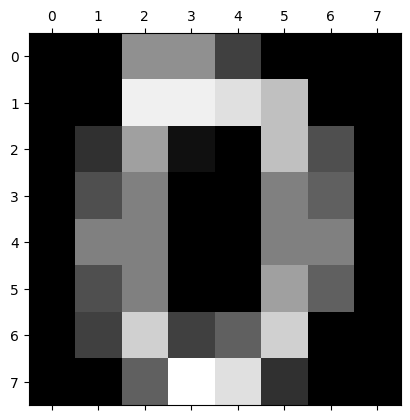

[ 0.  0.  9.  9.  4.  0.  0.  0.  0.  0. 15. 15. 14. 12.  0.  0.  0.  3.
 10.  1.  0. 12.  5.  0.  0.  5.  8.  0.  0.  8.  6.  0.  0.  8.  8.  0.
  0.  8.  8.  0.  0.  5.  8.  0.  0. 10.  6.  0.  0.  4. 13.  4.  6. 13.
  0.  0.  0.  0.  6. 16. 14.  3.  0.  0.] 0


In [ ]:
import matplotlib.pyplot as plt

plt.gray()
plt.matshow(X_train[1].reshape([8,8]))
plt.show()

print(X_train[1], Y_train[1])

In [ ]:
test_model = Model(64, 20, 30, 10)

training_losses, valdiation_loss = train(test_model,X_train, Y_train, X_test, Y_test, 0.5, 50, 8)

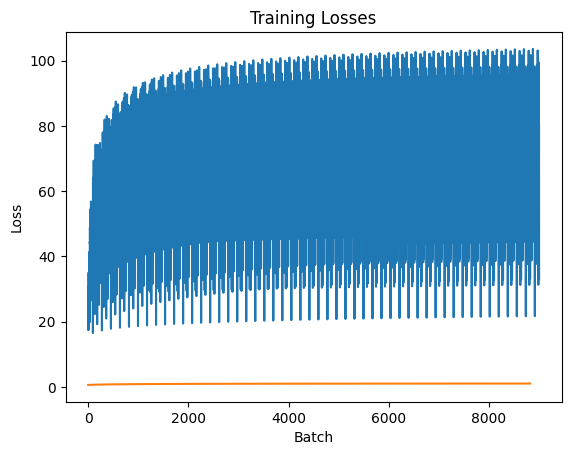

In [ ]:
batches = len(training_losses)
epochs = len(valdiation_loss)

batches_per_epoch = batches//epochs

plt.plot(range(batches), training_losses)

plt.plot(range(0, batches, batches_per_epoch), valdiation_loss)

plt.title('Training Losses')
plt.xlabel('Batch')
plt.ylabel('Loss')

plt.show()


# 5. Evaluate performance on validation/test set

In [ ]:
def evaluate(model, X, y):
    """Evaluate the model's accuracy on the given dataset (X, y)."""
    correct = 0

    for i in range(len(X)):
        pred = model.forward(X[i])[-1]

        if np.argmax(pred) == y[i]:
            correct += 1

    print(correct)
    print(len(X))
    print(correct/len(X))

evaluate(test_model, X_test, Y_test)

evaluate(test_model, X_train, Y_train)

34
360
0.09444444444444444
149
1437
0.10368823938761308
